Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

Objective: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

Dataset: This lab utilizes the Amazon UK product dataset which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

Part 1: Analyzing Best-Seller Trends Across Product Categories

Objective: Understand the relationship between product categories and their best-seller status.

    Crosstab Analysis:

        Create a crosstab between the product category and the isBestSeller status.

        Are there categories where being a best-seller is more prevalent?

        Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

    Statistical Tests:
        Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
        Compute Cramér's V to understand the strength of association between best-seller status and category.

    Visualizations:
        Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm

In [20]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [21]:
pd.set_option("display.max_columns", None)

In [22]:
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [23]:
#1.1 Create a crosstab between the product category and the isBestSeller status.
crosstab_result = pd.crosstab(df["category"], df["isBestSeller"]).sort_values(by=True, ascending=False).head(5)
crosstab_result

#Are there categories where being a best-seller is more prevalent?
#Yes, top categoties are grocery, health & prsonal care, baby, sports&outdoors, and power&hands tools

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306


In [24]:
#1.2 Conduct a chi-square test to determine if the best seller distribution is independent of the product category

# Chi-square test for 'category' and 'isbestseller'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value #p-value is 0 so it indicates that there is a significant dependency betweek product category and is best seller

(np.float64(32919.53645496928), np.float64(0.0))

In [25]:
#1.3 Compute Cramér's V to understand the strength of association between best-seller status and category.
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer") #result is 0.122, this is a low association.

0.1935111467206869

In [26]:
#Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
crosstab_result = crosstab_result.reset_index()
crosstab_melted = crosstab_result.melt(id_vars="category", value_vars=[True, False], var_name="isBestSeller", value_name="count")

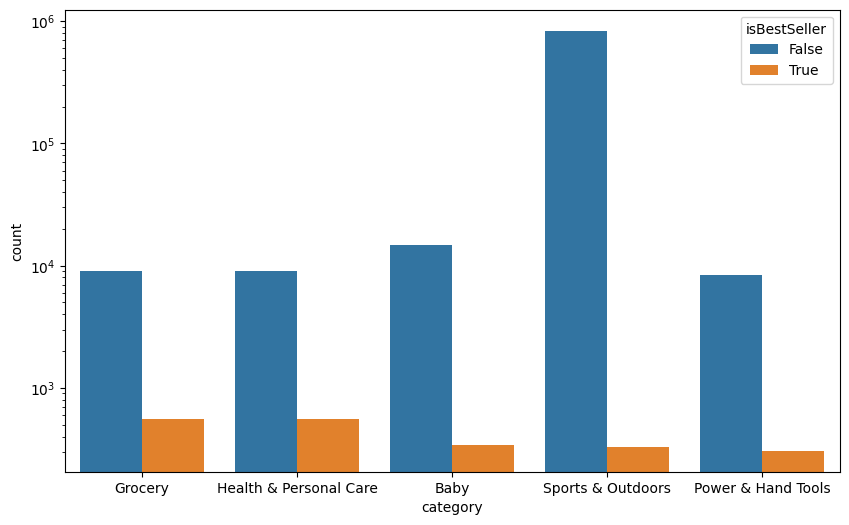

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="count", hue="isBestSeller", data=crosstab_melted)
plt.yscale('log')
plt.show()

Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Objective: Investigate how different product categories influence product prices.

    Preliminary Step: Remove outliers in product prices.

    For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

    Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

    Violin Plots:
        Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
        Which product category tends to have the highest median price? Don't filter here by top categories.

    Bar Charts:
        Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
        Which product category commands the highest average price? Don't filter here by top categories.

    Box Plots:
        Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
        Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [28]:
#2.1 Preliminary step: remove outliers in product prices.
def outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    #define the bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Identify the outliers:
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers

data_series = df["price"]
price_outliers = outliers(data_series)
print(price_outliers)

10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64


In [29]:
#what i want to do is replacing the outliers by the mean. But first i need to calculate the mean without the outliers
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
#define the bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mean_without_ouliers = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)].mean()
mean_without_ouliers.round(2)

np.float64(23.41)

In [30]:
#now, we define a function to replace the outliers with the calculated mean (without outliers)
def replace_outliers(a_price):
    if a_price < lower_bound:
        return mean_without_ouliers
    if a_price > upper_bound:
        return mean_without_ouliers
    return a_price

df["price_without_ouliers"] = df["price"].apply(replace_outliers) #now the data set contains a new column of prices with outliers substituted by the mean

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_808/3573456475.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x="category", y="price_without_ouliers", palette="coolwarm")


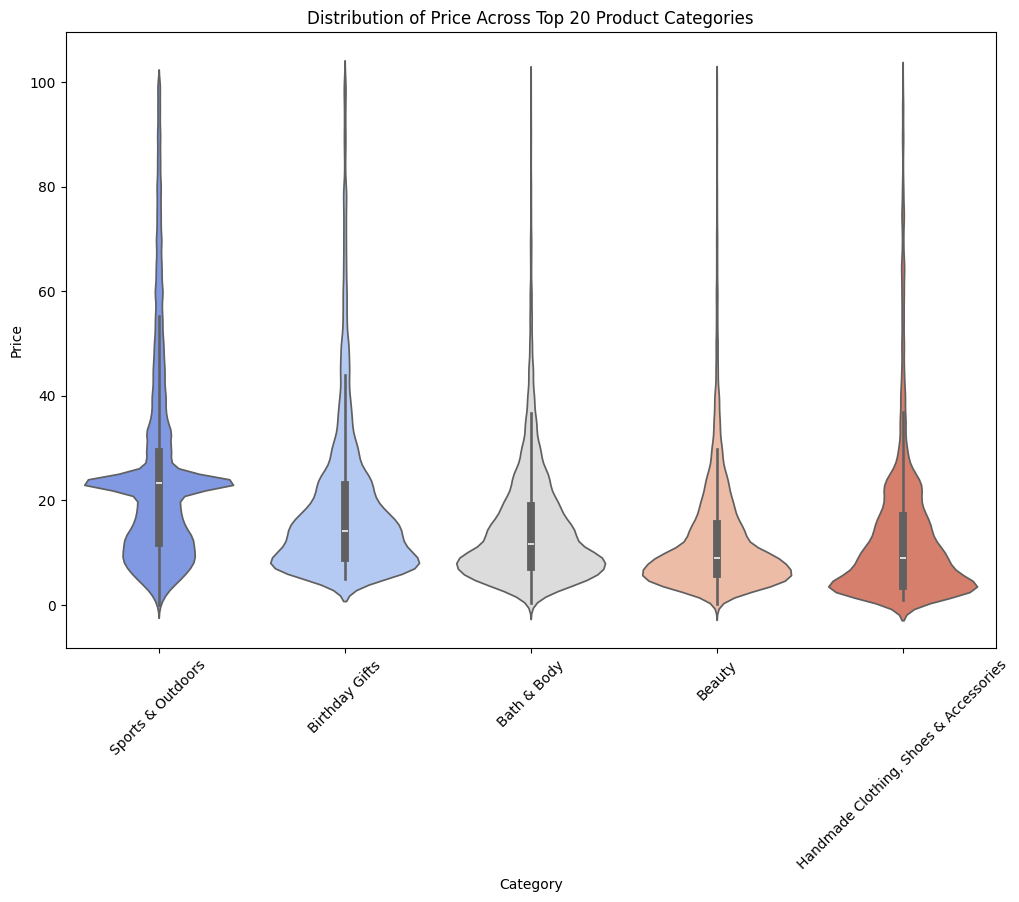

In [31]:
#2.2 Violin Plots:
# Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
# Which product category tends to have the highest median price? Don't filter here by top categories.

#i will do it only for 5 categories because i did 20 and it looked horrible.
top_5_categories = df["category"].value_counts().head(5).index
filtered_df = df[df["category"].isin(top_5_categories)]

plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_df, x="category", y="price_without_ouliers", palette="coolwarm")

plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Price")
plt.title("Distribution of Price Across Top 20 Product Categories")

plt.show()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_808/1230103961.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=av_price_top10_df, x="category", y="price_without_ouliers", palette="pastel")


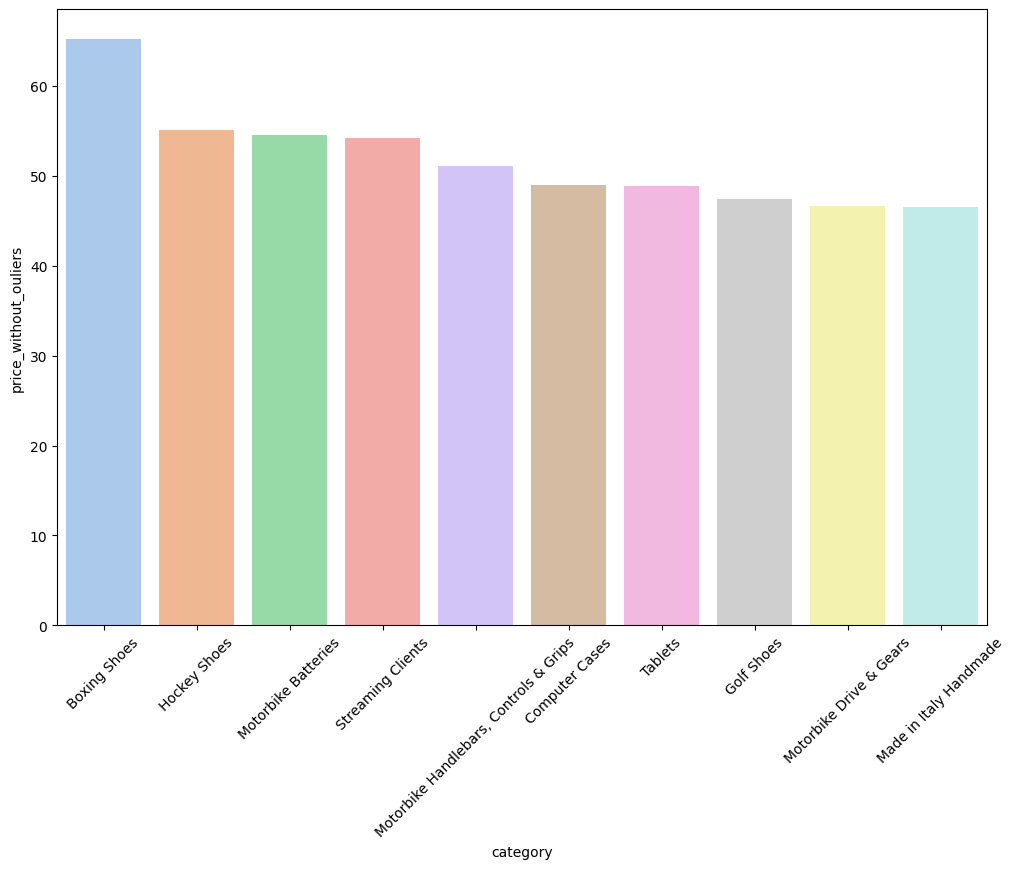

In [32]:
# 2.3 Bar Charts:
# Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
# Which product category commands the highest average price? Don't filter here by top categories.
av_price_top10_df = df[["category","price_without_ouliers"]].groupby("category").mean().sort_values(by="price_without_ouliers", ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=av_price_top10_df, x="category", y="price_without_ouliers", palette="pastel")
plt.xticks(rotation=45)

plt.show()

/var/folders/m3/cvmhd4j11f7968wyg9z4qfdr0000gn/T/ipykernel_808/1175854460.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='category', y='price_without_ouliers', palette="pastel")


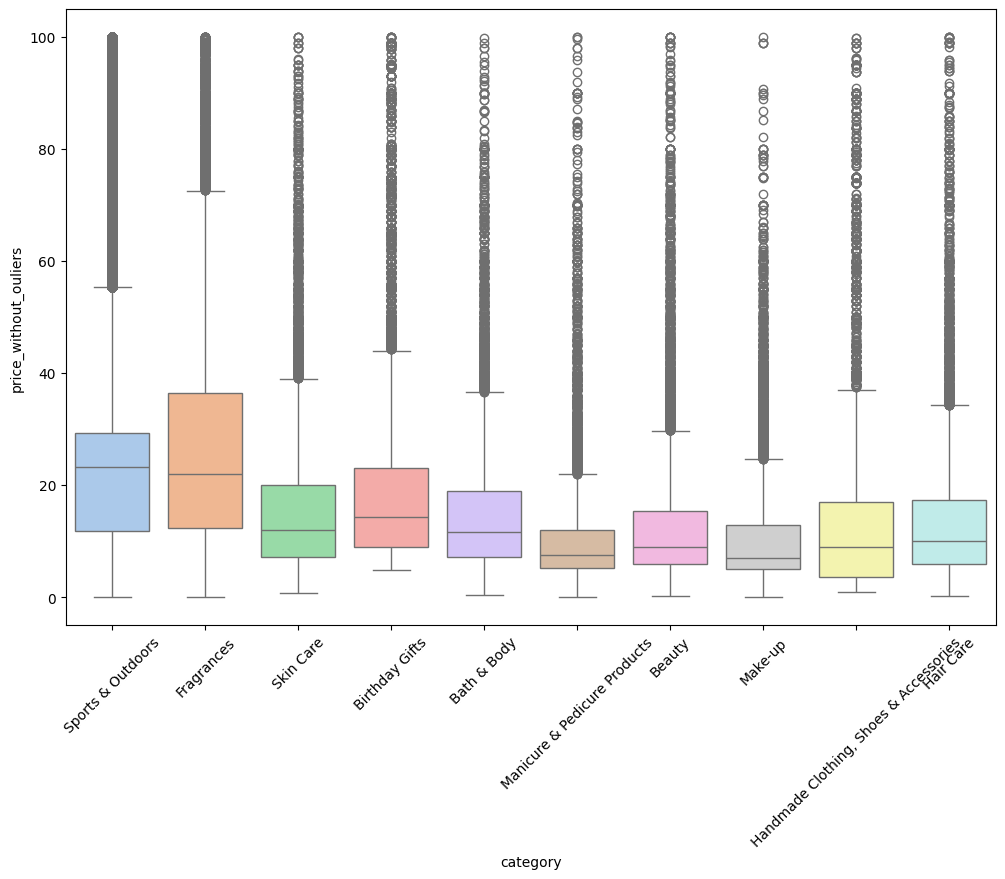

In [33]:
#2.4 Box Plots:
#Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
#Which category tends to receive the highest median rating from customers? Don't filter here by top categories.
top_10_categories = df["category"].value_counts().sort_values(ascending=False).head(10).index

filtered_df = df[df["category"].isin(top_10_categories)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='category', y='price_without_ouliers', palette="pastel")
plt.xticks(rotation=45)
plt.show() #top categories that receive the highest median rating from customers are sports adn fragances.

Part 3: Investigating the Interplay Between Product Prices and Ratings

Objective: Analyze how product ratings (stars) correlate with product prices.

    Correlation Coefficients:
        Calculate the correlation coefficient between price and stars.
        Is there a significant correlation between product price and its rating?

    Visualizations:
        Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
        Use a correlation heatmap to visualize correlations between all numerical variables.
        Examine if product prices typically follow a normal distribution using a QQ plot.

In [34]:
#3.1. Calculate the correlation coefficient between price and stars:
#Pearson correlation:
pearson_correlation = df['price_without_ouliers'].corr(df['stars'])
print(pearson_correlation)

# Spearman correlation
spearman_correlation = df['price_without_ouliers'].corr(df['stars'], method='spearman')
print(spearman_correlation)

#A value of -0.07 suggests a very weak negative linear relationship
#A value of -0.08 also suggests a very weak negative monotonic relationship.

-0.07224472096320464
-0.08745120479495654


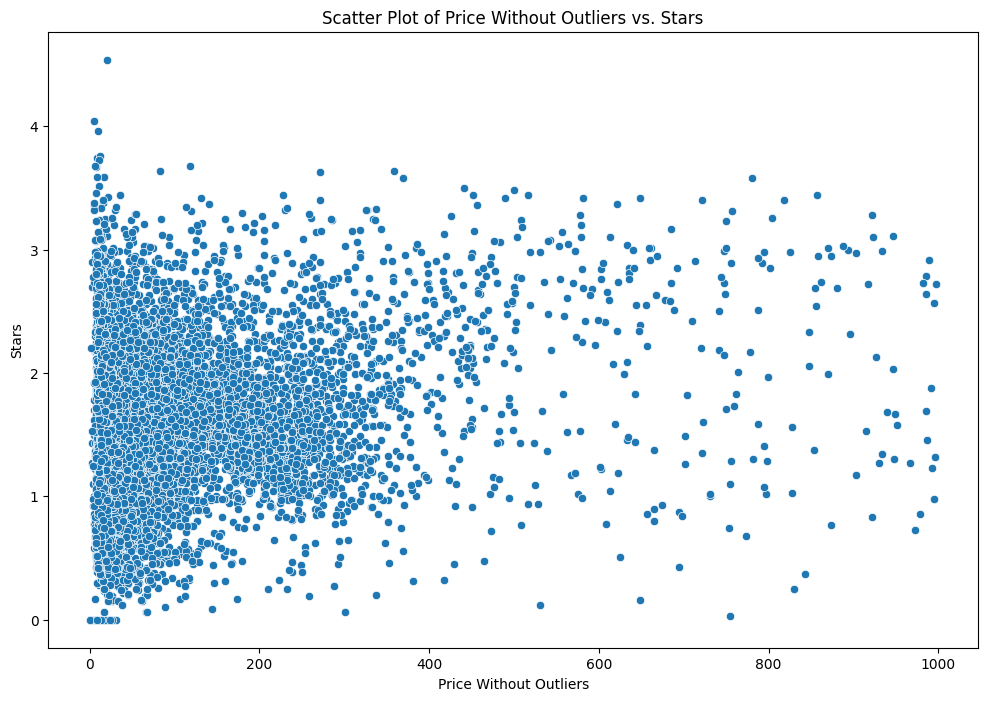

In [44]:
#3.2 use a scatter plot to visualize the relationship between the product rating and price. 
threshold = 1000
price_value_counts = df["price_without_ouliers"].value_counts().sort_index()
average_ratings = df.groupby("price_without_ouliers")["stars"].mean().round(2)

filtered_price_counts = price_value_counts[price_value_counts < threshold]

scatter_df = pd.DataFrame({
    "price": filtered_price_counts,
    "avg_rating": average_ratings,
}
)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=scatter_df, x='price', y='avg_rating')
plt.xlabel('Price Without Outliers')
plt.ylabel('Stars')
plt.title('Scatter Plot of Price Without Outliers vs. Stars')
plt.show()

#there is no significant correlation between price and rating.

In [47]:
#3.3 Use a correlation heatmap to visualize correlations between all numerical variables.
#first i need to create a df with the numerical variables
df.head(2)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category,price_without_ouliers
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers,21.99
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers,23.99


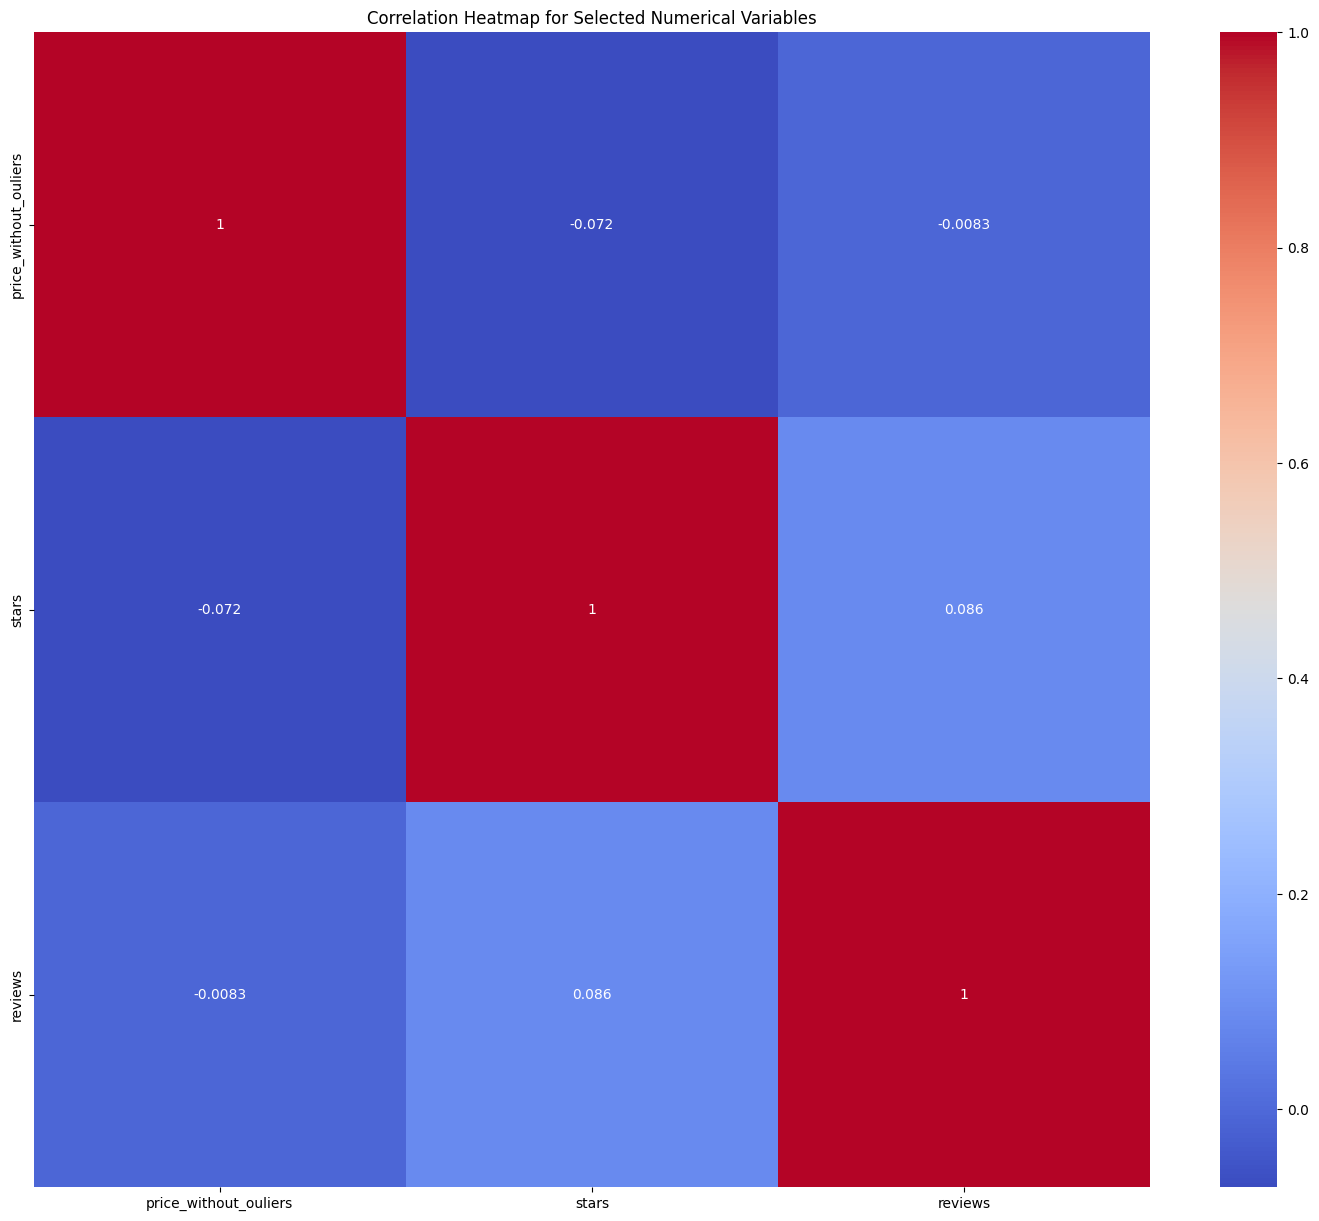

In [52]:
num_vars= ['price_without_ouliers', 'stars', "reviews"]
num_vars_df = df[num_vars]

correlation_matrix = num_vars_df.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

#nothing is correlated to nothing.

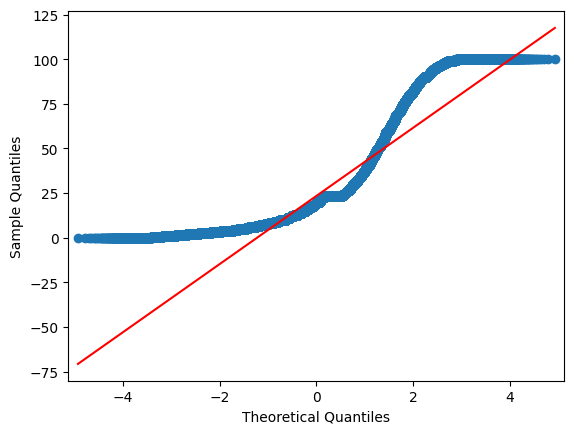

In [58]:
#3.4 Examine if product prices typically follow a normal distribution using a QQ plot.
sm.qqplot(df['price_without_ouliers'], line='s')

#mmmmm i think they follow a normal distribution ¡